In [1]:
import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import cuda
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from torch.optim import AdamW
from transformers import RobertaModel
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random

random.seed(1337)

device = 'cuda' if cuda.is_available() else 'cpu' # This invokes GPU if available, otherwise train on CPU

C:\Users\ndhem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Preprocessing Data

# Dataset is from Kaggle: https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset
# There are two columns, "Review" and "label"
# Review is the text from the respondent, and label is a binary indicator of positive sentiment

df = pd.read_csv("spotify_data.csv", encoding = 'latin-1') # Read in data

# Remove duplicates based on Review column only
df = df.drop_duplicates(subset = ['Review'], keep = 'first')

# Convert Label column: POSITIVE = 1, NEGATIVE = 0
df['label'] = df['label'].map({'POSITIVE': 1, 'NEGATIVE': 0})

# Sample 1000 of each class (2000 total)
positive_samples = df[df['label'] == 1].sample(n = 500, random_state = 1337)
negative_samples = df[df['label'] == 0].sample(n = 500, random_state = 1337)

# Combine and shuffle
df = pd.concat([positive_samples, negative_samples]).sample(frac = 1, random_state = 1337).reset_index(drop = True)

In [3]:
### Define CustomDataset Class

# PyTorch works best with a CustomDataset class
# This ensures all data is preprocessed the same, and tokenized dynamically

class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len = 512): # 512 characters is max length for RoBERTa
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe['Review']
        self.targets = dataframe['label']
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text) # This def is important as it returns the number of samples in the dataset

    def __getitem__(self, index): # Likewise, this def grabs one sample at a time
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split()) # This line removes extra whitespace between words, normalizing the input

        inputs = self.tokenizer.encode_plus(  # Here is where we tokenize the text (converting characters to arrays)
            comment_text,
            None,
            add_special_tokens = True, # Important for RoBERTa specifically. Adds <s> start token at beginning and </s> at end of text
            max_length = self.max_len,
            padding = 'max_length', # Must pad to ensure everything is the same size
            truncation = True,
            return_token_type_ids = True
        )

        # Three outputs from tokenizer
        ids = inputs['input_ids'] # The array of each converted word/subword
        mask = inputs['attention_mask'] # Binary column indicating which tokens are real (1) and which are padded (0)
        token_type_ids = inputs["token_type_ids"] # This isnt used

        return {
            'text': comment_text,
            'ids': torch.tensor(ids, dtype = torch.long),
            'mask': torch.tensor(mask, dtype = torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype = torch.long),
            'targets': torch.tensor(self.targets[index], dtype = torch.float)
        }

In [ ]:
### Split into Train and Validation

# It works best to have a train, a validation, and a test dataset
# The test dataset would be one which is not touched throughout the entire project until the model's performance is measured at the end

# First split: separate test set (10%)
train_val_dataset, test_dataset = train_test_split(df, test_size = 0.1, random_state = 1337, shuffle = True)

# Second split: separate train and validation from remaining 90% (70/20 split)
train_dataset, val_dataset = train_test_split(train_val_dataset, test_size = 0.222, random_state = 1337, shuffle = True)

train_dataset = train_dataset.reset_index(drop = True)
val_dataset = val_dataset.reset_index(drop = True)
test_dataset = test_dataset.reset_index(drop = True)

print("Full Dataset: {}".format(df.shape))
print("Train Dataset: {}".format(train_dataset.shape))
print("Validation Dataset: {}".format(val_dataset.shape))
print("Test Dataset: {}".format(test_dataset.shape))

# Defining Tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Create the datasets 
batch_size = 8 # The number of samples processed together before updating model weights (fewer is less stable updating, more requires greater GPU memory)
train_set = CustomDataset(train_dataset, tokenizer) # Combine the defined tokenizer with the CustomDataset Class and the train/val/test sets
val_set = CustomDataset(val_dataset, tokenizer)
test_set = CustomDataset(test_dataset, tokenizer)

params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0
          }

test_params = {'batch_size': batch_size,
                'shuffle': False,  # Don't shuffle test set
                'num_workers': 0
                }

train_loader = DataLoader(train_set, **params) # After creating our custom datasets, we send the data to the PyTorch DataLoader with our parameter selection
val_loader = DataLoader(val_set, **params)
test_loader = DataLoader(test_set, **test_params)

Full Dataset: (1000, 2)
Train Dataset: (700, 2)
Validation Dataset: (200, 2)
Test Dataset: (100, 2)


In [ ]:
### Create Customized Model

# Now we create a custom class for the model
# It can be as simple as just calling the pretrained model from HuggingFace
# Here, I add a dropout layer to act as regularization on the model
# During training a dropout of 0.3 will set 30% of the neurons to 0 randomly to avoid overfitting

class RoBERTaClass(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base') # The pretrained model from HuggingFace
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_classes) # This defines the outputs with num_classes
        
    def forward(self, ids, mask, token_type_ids = None):
        outputs = self.roberta(ids, attention_mask = mask)
        pooled_output = outputs.pooler_output # Use the pooled output (CLS token representation for entire text sequence)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [6]:
### Defining the Training Function

def train_model(model, train_dataset, val_dataset, num_epochs = 10, batch_size = 8, learning_rate = 3e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
    val_dataloader = DataLoader(val_dataset, batch_size = batch_size, drop_last = True)
    
    optimizer = AdamW(model.parameters(), lr = learning_rate) # Define optimizer. Adam is typical, but there are many different options
    
    loss_fn = nn.BCEWithLogitsLoss()  # For binary classification (single label, two classes)

    # BCEWithLogitsLoss() works for both binary (1 output) and multi-label (multiple outputs) classification
    # CrossEntropyLoss() is for multi-class classification where each sample has one label from multiple options

    # Learning rate scheduler 
    lr_scheduler = torch.optim.lr_scheduler.StepLR( 
        optimizer,
        step_size = 4, # Every 4 epochs, learning rate is reduced
        gamma = 0.2 # Multiplicative factor of learning rate decay  
    )

    # Track best model across all epochs
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs): # Each epoch goes through train then validation
        model.train() # Turn to training mode
        
        total_train_loss = 0

        # Training
        for batch in tqdm.tqdm(train_dataloader, desc = f"Epoch {epoch + 1} - Training"): # tqdm gives progress bars
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['targets'].to(device).unsqueeze(1)
            
            optimizer.zero_grad() # Necessary to zero gradient each epoch
            outputs = model(ids, mask, token_type_ids) # Send data through model
            loss = loss_fn(outputs, labels) # Get loss on the outputs
            loss.backward() # Begin backpropagation and compute gradients
            optimizer.step() # Optimize parameters to find the smallest loss
            total_train_loss += loss.item()
            
        train_loss = total_train_loss / len(train_dataloader)
        
        model.eval() # Turn to evaluation mode to use validation data
        total_val_loss = 0
        total_exact_matches = 0
        total_samples = 0
        all_preds = []
        all_labels = []
        
        # Validation
        with torch.no_grad(): # Stop gradient descent on validation set to benchmark performance
            for batch in tqdm.tqdm(val_dataloader, desc = f"Epoch {epoch + 1} - Validation"):
                ids = batch['ids'].to(device)
                mask = batch['mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                labels = batch['targets'].to(device).unsqueeze(1)
                outputs = model(ids, mask, token_type_ids)
                
                loss = loss_fn(outputs, labels)
                total_val_loss += loss.item()
                preds = torch.sigmoid(outputs) > 0.5 # Convert probabilities to actual 0 or 1 labels
                
                all_preds.append(preds.cpu().view(-1, preds.size(-1)))
                all_labels.append(labels.cpu().view(-1, labels.size(-1)))
                
                # Exact accuracy (Just accuracy in the single-label use)
                total_exact_matches += torch.sum(torch.all(preds == labels, dim = 1)).item()
                total_samples += labels.size(0)
        
        # Calculate metrics val_loss, exact_accuracy
        val_loss = total_val_loss / len(val_dataloader)
        exact_accuracy = total_exact_matches / total_samples

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
        
        # Cache learning rate for logging
        current_lr = optimizer.param_groups[0]['lr']
        
        print(
            f"Epoch {epoch + 1} | train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | "
            f"exact_acc: {exact_accuracy:.4f} |"
            f"lr: {current_lr:.2e}"
        )
        
        lr_scheduler.step()
    
    # Load best model weights before returning
    model.load_state_dict(best_model_state)

    return model

In [ ]:
### Train

batch_size = 16 # This is bound by GPU memory -- smaller batches will take less memory
epochs = 15
learning_rate = 4e-05 # (I believe) BERT paper suggests 3e-05 to 5e-05 learning rate

model = RoBERTaClass(num_classes = 1) # This dataset has 1 binary labels

# Begin the finetuning of the model
trained_model = train_model(
    model = model,
    train_dataset = train_set,
    val_dataset = val_set,
    num_epochs = epochs,
    batch_size = batch_size,
    learning_rate = learning_rate
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 12/12 [00:01<00:00, 10.45it/s]


Epoch 1 | train_loss: 0.5660 | val_loss: 0.4161 | exact_acc: 0.8750 |lr: 4.00e-05


Epoch 2 - Validation: 100%|██████████| 12/12 [00:01<00:00, 10.51it/s]


Epoch 2 | train_loss: 0.3264 | val_loss: 0.2962 | exact_acc: 0.9115 |lr: 4.00e-05


Epoch 3 - Validation: 100%|██████████| 12/12 [00:01<00:00, 10.54it/s]


Epoch 3 | train_loss: 0.1948 | val_loss: 0.3816 | exact_acc: 0.8750 |lr: 4.00e-05


Epoch 4 - Validation: 100%|██████████| 12/12 [00:01<00:00, 10.55it/s]


Epoch 4 | train_loss: 0.1633 | val_loss: 0.3513 | exact_acc: 0.9167 |lr: 4.00e-05


Epoch 5 - Validation: 100%|██████████| 12/12 [00:01<00:00, 10.57it/s]


Epoch 5 | train_loss: 0.0968 | val_loss: 0.3594 | exact_acc: 0.9115 |lr: 8.00e-06


Epoch 6 - Validation: 100%|██████████| 12/12 [00:01<00:00, 10.54it/s]


Epoch 6 | train_loss: 0.0821 | val_loss: 0.3685 | exact_acc: 0.9115 |lr: 8.00e-06


Epoch 7 - Validation: 100%|██████████| 12/12 [00:01<00:00, 10.59it/s]


Epoch 7 | train_loss: 0.0614 | val_loss: 0.3839 | exact_acc: 0.9115 |lr: 8.00e-06


Epoch 8 - Validation: 100%|██████████| 12/12 [00:01<00:00, 10.59it/s]


Epoch 8 | train_loss: 0.0576 | val_loss: 0.3962 | exact_acc: 0.9010 |lr: 8.00e-06


Epoch 9 - Validation: 100%|██████████| 12/12 [00:01<00:00, 10.55it/s]


Epoch 9 | train_loss: 0.0505 | val_loss: 0.3976 | exact_acc: 0.9062 |lr: 1.60e-06


Epoch 10 - Validation: 100%|██████████| 12/12 [00:01<00:00, 10.56it/s]


Epoch 10 | train_loss: 0.0595 | val_loss: 0.4091 | exact_acc: 0.9062 |lr: 1.60e-06


Epoch 11 - Validation: 100%|██████████| 12/12 [00:01<00:00, 10.54it/s]


Epoch 11 | train_loss: 0.0482 | val_loss: 0.4023 | exact_acc: 0.9062 |lr: 1.60e-06


Epoch 12 - Validation: 100%|██████████| 12/12 [00:01<00:00, 10.56it/s]


Epoch 12 | train_loss: 0.0457 | val_loss: 0.4048 | exact_acc: 0.9062 |lr: 1.60e-06


Epoch 13 - Validation: 100%|██████████| 12/12 [00:01<00:00, 10.64it/s]


Epoch 13 | train_loss: 0.0473 | val_loss: 0.4059 | exact_acc: 0.9062 |lr: 3.20e-07


Epoch 14 - Validation: 100%|██████████| 12/12 [00:01<00:00, 10.58it/s]


Epoch 14 | train_loss: 0.0407 | val_loss: 0.4079 | exact_acc: 0.9062 |lr: 3.20e-07


Epoch 15 - Validation: 100%|██████████| 12/12 [00:01<00:00, 10.50it/s]

Epoch 15 | train_loss: 0.0406 | val_loss: 0.4105 | exact_acc: 0.9062 |lr: 3.20e-07


Testing: 100%|██████████| 13/13 [00:00<00:00, 20.81it/s]


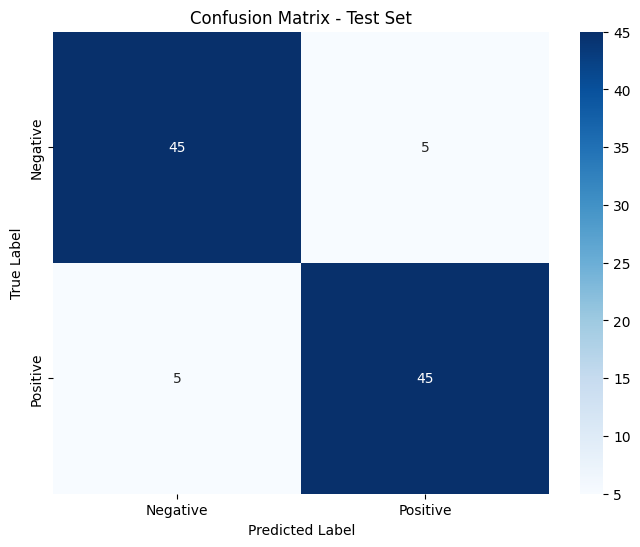


Classification Report - Test Set:
              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90        50
    Positive       0.90      0.90      0.90        50

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



In [8]:
### Evaluate on Test Set

# Model checkpointing!!!

trained_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm.tqdm(test_loader, desc = "Testing"):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        labels = batch['targets'].unsqueeze(1)
        
        outputs = trained_model(ids, mask)
        preds = torch.sigmoid(outputs) > 0.5
        
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds).flatten().astype(int)
all_labels = np.concatenate(all_labels).flatten().astype(int)

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', 
            xticklabels = ['Negative', 'Positive'],
            yticklabels = ['Negative', 'Positive'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Print classification report
print("\nClassification Report - Test Set:")
print(classification_report(all_labels, all_preds, 
                          target_names = ['Negative', 'Positive']))